# Singular Value Decomposition (SVD)

for video background removal 

This notebook shows the use of Singular Value Decomposition for the purpose of background removal from a survelliance video stream. The project idea originally comes from Rachel Thomas' FastAI course for 
[Computational Linear Algebra - Chapter 3](https://github.com/fastai/numerical-linear-algebra). The dataset comes from the [BMC 2012 Background Models Challenge Dataset](http://bmc.iut-auvergne.com/?page_id=24)

In [1]:
import os
import scipy

import numpy as np
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

import matplotlib.pyplot as plt
from sklearn import decomposition

%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

#### our video: 

In [2]:
video = mpy.VideoFileClip("video/Video_003/Video_003.avi")

In [3]:
#original surveillance video 
video.subclip(0,50).ipython_display(width=300)

100%|█████████████████████████████████████████████████████████████████████████████▊| 350/351 [00:00<00:00, 1119.88it/s]


#### helper functions 

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def check_frames(clip, frames): 
    num_frames = clip.fps * clip.duration
    desired_dur = frames / clip.fps 
    assert desired_dur <= clip.duration, 'too many frames requested! must be less than {}'.format(num_frames)

def video_to_matrix(clip, frames=5, scale=50):
    '''create a numpy matrix from the video clip
    
    args: 
    clip : moviepy video object 
    k : num frames 
    scale : (int) resize scale, percentage of original 
    '''
    check_frames(clip, frames)
    image_list = []
    for frame in range(frames):
        time = frame/clip.fps
        gray = rgb2gray(clip.get_frame(time)).astype(int)
        resized = scipy.misc.imresize(gray, scale)
        flattened = resized.flatten() 
        image_list.append(flattened)
    return np.vstack(image_list).T

In [5]:
scale = 50  # Adjust scale to change resolution of image
dims = (int(240 * (scale/100)), int(320 * (scale/100)))

video_mat = video_to_matrix(video, frames=794, scale=scale)
print('dims: {} \nvideo matrix shape {}'.format(dims, video_mat.shape))

dims: (120, 160) 
video matrix shape (19200, 794)


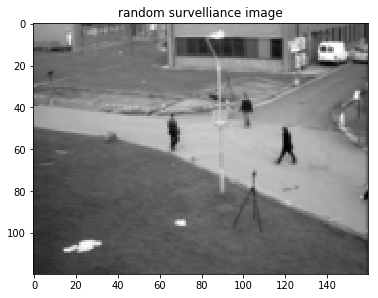

In [6]:
plt.figure(figsize=(6, 6))
plt.title('random survelliance image')
plt.imshow(np.reshape(video_mat[:,9], dims), cmap='gray');

the curves show motion in the image!


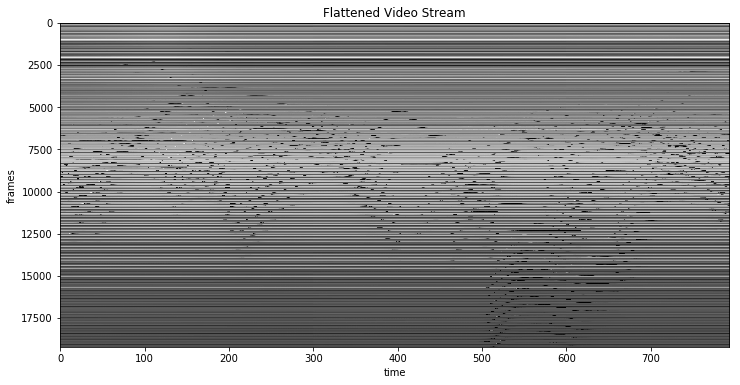

In [7]:
plt.figure(figsize=(12, 12))
plt.title('Flattened Video Stream')
plt.xlabel('time')
plt.ylabel('frames')
plt.imshow(video_mat, aspect=.02, cmap='gray')
print('the curves show motion in the image!')

In the image above, the horizontal flat lines are the same pixel throughout the video stream. The curves show changes is that pixel, the motion of the people. Flat lines mean no motion, and mathematically, low variance. The motion can be viewed as noise in an otherwise steady signal. So noise filtering should allow us to extract the people. 

## Naive background removal 

Sorting the array yeilds the image below. We can take the mode to get a value that presumably does not have any motion. We can use this to subtract the background out. 

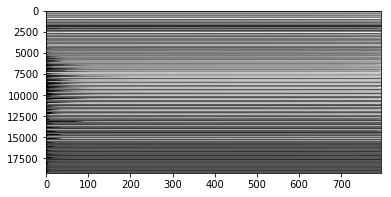

In [8]:
plt.imshow(np.sort(video_mat), aspect=.02, cmap='gray')

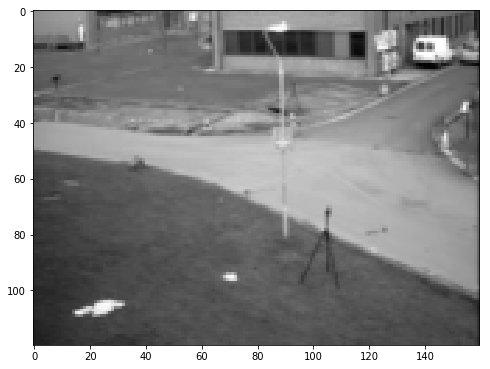

In [9]:
mode_col = int(video_mat.shape[1]/2)
sorted_mat = np.sort(video_mat)
background = sorted_mat[:, mode_col]

plt.figure(figsize=(8, 8))
plt.imshow(background.reshape(dims), cmap='gray')

Looks pretty good. Now let's look at the people. 

In [10]:
people = video_mat - background.reshape(-1, 1)
people.shape

(19200, 794)

In [35]:
def plot_two_images(img1, img2, cmap='gray'): 
    
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 2, 1);  plt.title("Original Image")
    plt.imshow(img1, cmap='gray')


    plt.subplot(1, 2, 2); plt.title("Background Removed")
    plt.imshow(img2, cmap='gray')
    plt.show()

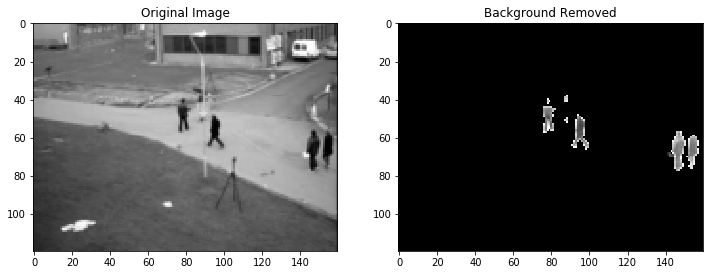

In [36]:
plot_two_images(video_mat[:,20].reshape(dims),
                people[:, 20].reshape(dims))

Cool! But noisy. We can clean that up. 

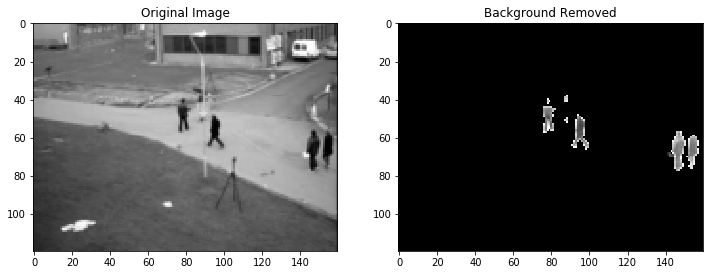

In [37]:
people[(people < 25) | (people > 210)] = 0
plot_two_images(video_mat[:,20].reshape(dims),
                people[:, 20].reshape(dims))

This is messy. We have to set these thresholds to clean the processed image. We can't be sure what these parameters would be for different images. There must be a more robust way... Let's use some Lienar Algebra. 

## Singular Value Decomposition 

We can factorize our video matrix using SVD to extract the "concepts" of our matrix. In this case, the core concepts should be motion artifacts. In the equation below, A is our input video matrix, U is a matrix with dimenions $[m, r]$ where m is the single frame from the video and r is the number of "concepts", $\Sigma$ is a diagnoal matrix representing of size $[r, r]$ where the magnitude of any $\Sigma_{ij}$ component is the strength of that component, and Vh is the transpose of a matrix of shape $[r, n]$ where n is the number of frames in the video. 

$$A = U\Sigma V^T $$ 

We use sklearn's decomposition API to perform the calculation. `decomposition.randomized_svd` has the argument `n_components`, which is a hyperparamter that represents the variable $r$ above. It is the nubmer of "concepts" we are trying to abstractly model. We will arbitrarily set it to two, but it will eventually need to be tuned in a realistic use case. 

In [32]:
U, S, Vt = decomposition.randomized_svd(video_mat, 10)
print (U.shape, S.shape, Vt.shape)

(19200, 10) (10,) (10, 794)


In [33]:
low_rank = U @ np.diag(S) @ Vt
low_rank.shape

(19200, 794)

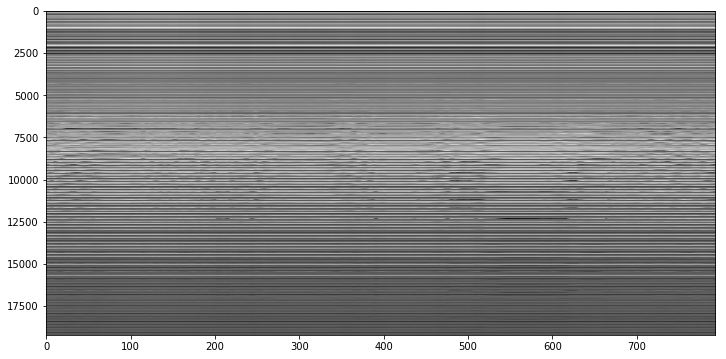

In [34]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, aspect=0.02, cmap='gray')

As we can see, this low rank matrix should represent the steady signal of unchanging background. We can see a few variations around 10000-12500, but they look minor. To filter our noise, the motion artifacts, we can subtract our original video matrix (A) from this low rank matrix, and the difference should be the background removal we are looking for. 

In [16]:
SVD_bg_removed = video_mat-low_rank

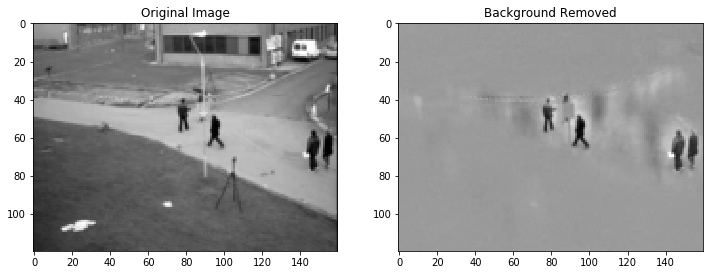

In [38]:
plot_two_images(video_mat[:,20].reshape(dims),
                SVD_bg_removed[:, 20].reshape(dims), cmap='gray')

And with a little clipping 

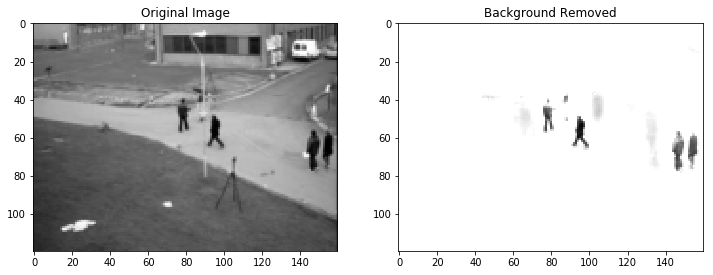

In [41]:
SVD_clipped = np.clip(SVD_bg_removed, None, -10)

plot_two_images(video_mat[:,20].reshape(dims),
                SVD_clipped[:, 20].reshape(dims), cmap='gray')

Awesome! This frame is much cleaner. We can make out much more detail in each individual person, and no tuning is needed. I am happy with this, so lets build out a function to process and save a whole video frame. 

In [39]:
def SVD_background_removal(clip, frames=5, scale=100, n_components=2):
    #convert a video clip into a video tensor with SVD background removal 
    
    #format the output dimensions 
    shp = np.array(video.get_frame(0).shape)
    shp[2] = -1
    
    #perform SVD
    A = video_to_matrix(clip, frames=frames, scale=scale)
    U, s, Vh = decomposition.randomized_svd(A, n_components)
    low_rank = U @ np.diag(s) @ Vh
    
    #remove background from input video tensor 
    bg_removed = A-low_rank
    bg_removed = bg_removed.reshape(shp)
    return bg_removed

In [40]:
bg = SVD_background_removal(video, frames=794)
bg.shape

(240, 320, 794)

[MoviePy] >>>> Building video video/Video_003/Video_003_OUT.mp4
[MoviePy] Writing video video/Video_003/Video_003_OUT.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 795/795 [00:45<00:00, 17.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/Video_003/Video_003_OUT.mp4 



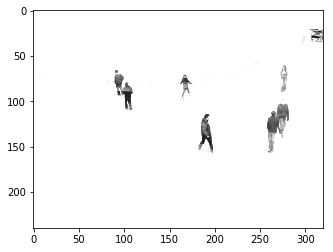

In [20]:
#make a video - hacky solution with mplfig_to_npimage 

fps = video.fps
fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    
    #processed frame 
    img = bg[:, : ,int(t*fps)]
    
    #clip edges (noise)
    img = np.clip(img, None, -10)
    
    #output 
    ax.imshow(img, cmap='gray')
    out = mplfig_to_npimage(fig)[40:250, 78:360, :]
    out = scipy.misc.imresize(out, (240, 320))
    return out 

#write to video 
animation = mpy.VideoClip(make_frame, duration=video.duration)
animation.write_videofile('video/Video_003/Video_003_OUT.mp4', fps=fps)

## Compare! 

In [21]:
video = mpy.VideoFileClip("video/Video_003/Video_003.avi")
#original surveillance video 
video.subclip(0,50).ipython_display(width=300)

100%|█████████████████████████████████████████████████████████████████████████████▊| 350/351 [00:00<00:00, 1006.42it/s]


In [22]:
out = mpy.VideoFileClip("video/Video_003/Video_003_OUT.mp4")
out.subclip(0,50).ipython_display(width=300)

100%|██████████████████████████████████████████████████████████████████████████████▊| 350/351 [00:00<00:00, 600.81it/s]
